<a href="https://colab.research.google.com/github/manugaur99/VRPTTW/blob/main/pretrained_simclr_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install pips (hidden).
!pip install diffdist wldhx.yadisk-direct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for diffdist: filename=diffdist-0.1-py3-none-any.whl size=6553 sha256=951f1baf47def4827dd316e29c02f6361c4c31e4c44c19114f410682ad34a5e3
  Stored in directory: /root/.cache/pip/wheels/58/eb/5d/4878c7186753c09afacb2a43a74b45289488ebc62e9576565e
Successfully built diffdist


In [ ]:
#@title download pre-trained models and imagenet-mini (hidden).
!curl -L $(yadisk-direct https://yadi.sk/d/Sg9uSLfLBMCt5g?w=1) -o pretrained_models.zip
!unzip pretrained_models.zip 



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  868M    0  868M    0     0   9.8M      0 --:--:--  0:01:28 --:--:-- 10.1M
Archive:  pretrained_models.zip
  inflating: pretrained_models/resnet50_cifar10_bs1024_epochs1000.pth.tar  
  inflating: pretrained_models/resnet50_cifar10_bs1024_epochs1000_linear.pth.tar  
  inflating: pretrained_models/resnet50_imagenet_bs2k_epochs200.pth.tar  
  inflating: pretrained_models/resnet50_imagenet_bs2k_epochs200_linear.pth.tar  
  inflating: pretrained_models/resnet50_imagenet_bs2k_epochs600.pth.tar  
  inflating: pretrained_models/resnet50_imagenet_bs2k_epochs600_linear.pth.tar  
  inflating: pretrained_models/resnet50_imagenet_bs512_epochs100.pth.tar  
  inflating: pretrained_models/resnet50_imagenet_bs512_epochs100_linear.pth.tar  


In [ ]:
!curl -L $(yadisk-direct https://yadi.sk/d/fGSnPLKHbnFdbQ?w=1) -o imagenet-mini.zip
!unzip imagenet-mini.zip > zip.out

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 75.5M    0 75.5M    0     0  4247k      0 --:--:--  0:00:18 --:--:-- 10.7M


In [ ]:
!git clone https://github.com/AndrewAtanov/simclr-pytorch.git

Cloning into 'simclr-pytorch'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 81 (delta 31), reused 53 (delta 13), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [ ]:
import sys
sys.path.append('./simclr-pytorch')

In [ ]:
%env IMAGENET_PATH=./imagenet-mini/raw-data

env: IMAGENET_PATH=./imagenet-mini/raw-data


In [ ]:
import torch
import models
from utils import utils
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.dpi']=300

# ImageNet Prediction

In [ ]:
device = torch.device('cuda')

# load linear model chekpoint
ckpt = torch.load('./pretrained_models/resnet50_imagenet_bs2k_epochs600_linear.pth.tar', map_location=device)
# set path to the corresponding encoder checkpoint
ckpt['hparams'].encoder_ckpt = './pretrained_models/resnet50_imagenet_bs2k_epochs600.pth.tar'

model = models.ssl.SSLEval.load(ckpt, device=device)
model.encoder.eval()
model.eval()

IMAGENET_PATH = ./imagenet-mini/raw-data
IMAGENET_PATH = ./imagenet-mini/raw-data
** Using avgpool **
======> Encoder: output dim 2048 | 25.557M parameters


In [ ]:
!pip install modelsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for modelsummary: filename=modelsummary-1.1.7-py3-none-any.whl size=6954 sha256=1c9b8d8ddc4ca2397cebf963bcb5bdb3462c3f8148a38efd3d1dea3af988dea4
  Stored in directory: /root/.cache/pip/wheels/43/00/2f/2a3ee442f1003b38a85f754ec4c1a1f10ff1c4267e391ea03d
Successfully built modelsummary


In [ ]:
# from modelsummary import summary

# # # show input shape
# summary(model, torch.zeros((1, 3, 64, 64)), show_input=True)

RuntimeError: ignored

In [ ]:
# set number of loader workers and batch_size
model.hparams.workers = 2
model.hparams.batch_size = 100

In [ ]:
model.prepare_data()
trainloader, testloader = model.dataloaders()

Train size: 504
Test size: 100


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
id2id = {0: 260, 1:951}
torch.manual_seed(42)
x, y = next(iter(testloader))
y = torch.Tensor(list(map(lambda y_: id2id[y_], y.numpy())))
x, y = x.cuda(), y.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:424: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(-0.5, 2248.5, 2248.5, -0.5)

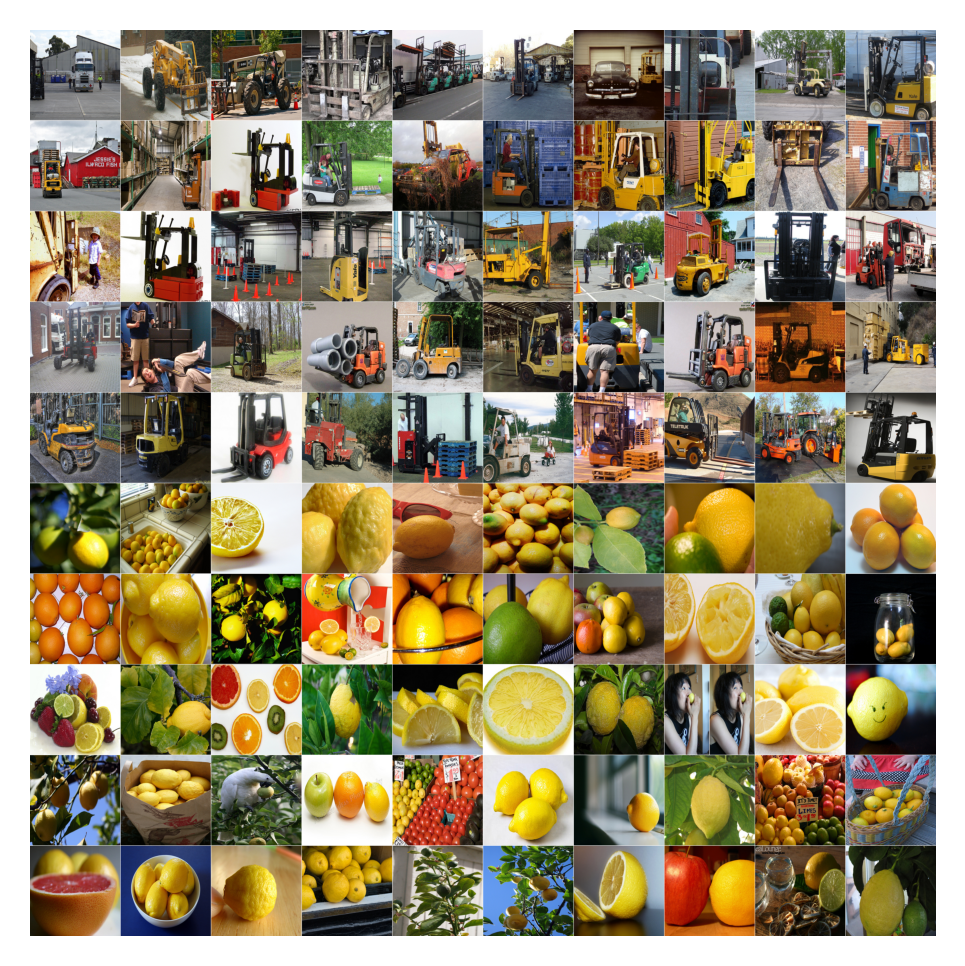

In [ ]:
plt.imshow(utils.viz_array_grid(x[:100]/255., 10, 10, 1))
plt.axis('off')

In [ ]:
# representations
h = model.encoder(x/255., out='h')
# linear predictions
p = model(h)
print(f'Accuracy: {(p.argmax(1) == y).float().mean():.3f}')

Accuracy: 0.270


In [ ]:
p.argmax(1)
# 260 [n03384352 - forklift] are confused with 561 [n03532672 - hook, claw] 😪
# the lemons 319 [n07749582 - lemon] are mostly fine 😀 but somtemes got confused with 950 [n04597913 - wooden spoon]

tensor([867, 803, 866, 561, 561, 561, 468, 561, 561, 561, 425, 624, 561, 561,
        595, 561, 561, 561, 856, 561, 561, 561, 561, 561, 561, 517, 561, 561,
        561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561,
        561, 561, 561, 561, 561, 561, 561, 561, 951, 948, 950, 951, 951, 951,
        951, 950, 951, 951, 950, 950, 950, 828, 951, 950, 951, 950, 951, 725,
        951, 951, 950, 951, 951, 950, 950, 629, 951, 951, 951, 951,  89, 950,
        950, 951, 950, 951, 951, 790, 950, 950, 950, 951, 951, 951, 950, 951,
        951, 951], device='cuda:0')